# HPC Project Part 2, SN: 15050727
The following notebook exhibits my naive and performance enhanced application of the finite difference method to a parabolic Poisson equation used to for the experiments presented in the report. 

I will begin this notebook by importing the necessary libraries and defining some functions that are useful implementing initial $g(x, y)$ values. 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from numpy.random import RandomState
import pyopencl as cl
import time
%matplotlib inline

In [2]:
def initial_conditions(in_grid):
    """
    Fills an array with ones near the centre.

    Parameters
    ----------
    in_grid : np.ndarray
        A (N, N) float64 array to be filled with ones,
        N must be divisible by 4.  

    Returns
    -------
    A (N, N) float64 array with ones near the centre
    """
    # nested for loop to find centre points
    for i in range(len(in_grid[0])):
        for j in range(len(in_grid[0])):
            # checking if point is near centre
            if i > len(in_grid[0])/4:
                if i < 3*len(in_grid[0])/4:
                    if j > len(in_grid[0])/4:
                        if j < 3*len(in_grid[0])/4:
                            in_grid[i][j] = 1

    return in_grid

def initial_conditions_assymetric(in_grid, N):
    """
    Fills an array with ones randomly for 20% of the
    grid. 

    Parameters
    ----------
    in_grid : np.ndarray
        A (N, N) float64 array to be filled with ones,
        N must be divisible by 4.       
    in_grid : integer
        An integer describing the length of the sides
        of the in_grid
    Returns
    -------
    A (N, N) float64 array ones randomly added throughout
    """
    in_grid = in_grid.flatten()
    # produce same grid every time with seed
    seeder = RandomState(1234567891)
    # calculate random indices
    indices = seeder.choice(np.arange(in_grid.size), replace=False,
                            size=int(in_grid.size * 0.2))
    # fill at corresponidng indices and reshape for output 
    in_grid[indices] = 1
    in_grid = np.reshape(in_grid, (N, N))
    return in_grid

## Naive Implementation ##

Next I will define the OpenCL kernel string for the naive implementation of the finite difference method and build the corresponding program.

In [3]:
kernel_string = """
__kernel void discretiseOpenCL(const int timeStep,
                               const int kernel_dim, 
                               __global double* result, 
                               __global double* sigma)
{

    // Thread indetifiers
    int i = get_global_id(0);
    int j = get_global_id(1);  

    // initialise 
    int height = kernel_dim; 
    int width = kernel_dim;
    int sigma_height = height + 2; 
    double h = (double)1 / (height + 1);
    
    // hard coded delta_T for the sigma used 
    double delta_T = (h * h) / (4 * 7.38);
    
    // read sigma data from memory buffer
    double sigma_i_j = sigma[(i+1) * sigma_height + j + 1];
    double sigma_i_plus_one_j = sigma[(i+1+1) * sigma_height 
                                        + j + 1];
    double sigma_i_minus_one_j = sigma[(i+1-1) * sigma_height 
                                        + j + 1];
    double sigma_i_j_plus_one = sigma[(i+1) * sigma_height 
                                        + j + 1 + 1];
    double sigma_i_j_minus_one = sigma[(i+1) * sigma_height 
                                        + j + 1 - 1];

    // calculate approximation of points not on the grid
    double sigma_x_forward = 0.5 * (sigma_i_j +
                                    sigma_i_plus_one_j);
    double sigma_y_forward = 0.5 * (sigma_i_j + 
                                    sigma_i_j_plus_one);
    double sigma_x_backward = 0.5 * (sigma_i_j + 
                                     sigma_i_minus_one_j);
    double sigma_y_backward = 0.5 * (sigma_i_j + 
                                     sigma_i_j_minus_one);
    
    // read u data 
    double u_i_j = result[((timeStep-1) * height * width) 
                          + i * height + j];
    double u_i_plus_one_j = result[((timeStep-1) * height * width) 
                                   + (i + 1) * height + j];
    double u_i_minus_one_j = result[((timeStep-1) * height * width) 
                                    + (i - 1) * height + j];
    double u_i_j_plus_one = result[((timeStep-1) * height * width) 
                                   + i * height + j + 1];
    double u_i_j_minus_one = result[((timeStep-1) * height * width) 
                                   + i * height + j - 1];

    // implicitly deal with boundaries
    if (i == 0) { 
        u_i_minus_one_j = 0.0;
    }
    if (i == kernel_dim - 1) { 
        u_i_plus_one_j = 0.0;
    }
    if (j == 0) { 
        u_i_j_minus_one = 0.0;
    }
    if (j == kernel_dim - 1) { 
        u_i_j_plus_one = 0.0;
    }

    // do calculations
    double first = sigma_x_forward * (u_i_plus_one_j - u_i_j) / h; 
    double second = sigma_x_backward * (u_i_j - u_i_minus_one_j) / h;
    double third = sigma_y_forward * (u_i_j_plus_one - u_i_j) / h;
    double fourth = sigma_y_backward * (u_i_j - u_i_j_minus_one) / h;

    double part_one = (first - second) / h;
    double part_two = (third - fourth) / h;
    
    double res = part_one + part_two; 
    
    // write to result buffer
    result[(timeStep * height * width) + i*height + j] = u_i_j + delta_T * res;
    
}
"""

Now I will define a function that implements the above kernel string for a given number of time steps.

In [4]:
def discretise_OpenCL(N, time_steps, asymmetric):
    """
    Solves parabolic possion equation 

    Parameters
    ----------
    N : integer
        An integer describing the length of one 
        side of the grid
    
    time_steps : integer
        An number of forward time steps to do
        
    asymmetric: bool 
        A boolean value to determine g(x, y)

    Returns
    -------
    A (N, N, time_steps) float64 array describing time evolution
    """
    # make a sigma vector, using the same random seed 
    # so that the random values are the same at each iteration
    seeder = RandomState(1234567890)
    sigma = np.exp(seeder.normal(1, 0.2, (N+2)*(N+2), ))
    
    # Add g(x, y) of choice 
    in_grid = np.zeros((time_steps + 1, N, N), dtype='float64')
    in_grid_init = in_grid[0]
    if asymmetric:
        in_grid_init = initial_conditions_assymetric(in_grid_init, N)
    else: 
        in_grid_init = initial_conditions(in_grid_init)
        
    in_grid[0] = in_grid_init

    # build an queue 
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    prg = cl.Program(ctx, kernel_string).build()
    kernel = prg.discretiseOpenCL
    
    # Setup buffers and kernel
    result_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR, hostbuf=in_grid)
               
    sigma_buffer = cl.Buffer(ctx, 
                             mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=sigma)
    
    # Compute time steps in series 
    for i in range(1, time_steps+1):
        event = kernel(queue,
                       (N, N),
                       (1, 1),
                       np.int32(i),
                       np.int32(N),
                       result_buffer, 
                       sigma_buffer)
        
    cl.enqueue_copy(queue, in_grid, result_buffer) 
    

    return in_grid

Find the benchmarked output for a 32 by 32 grid for 10 forward time steps below. Along with corresponding plots at different t values. 

In [5]:
time_steps = 10
N = 32
# benchmarking used for report
start = time.time()
output = discretise_OpenCL(N, time_steps, False)
end = time.time()
print("Seconds elapsed for "+str(time_steps) 
      + " timesteps: " +str(end - start))

Seconds elapsed for 10 timesteps: 0.024132728576660156


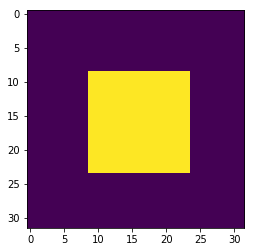

In [6]:
plt.imshow(output[0])

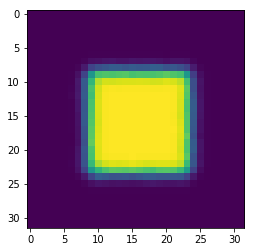

In [7]:
plt.imshow(output[5])

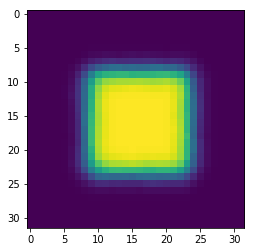

In [8]:
plt.imshow(output[10])

## Optimised Implementation ##

Next, I will present the kernel string, along with the function to invoke it I developed to try to optimise performance.

In [9]:
kernel_string_opt = """
__kernel void discretiseOpenCLOpt(const int timeStep,
                               const int kernel_dim, 
                               __global double* result, 
                               __global double* sigma)
{

    // Thread indetifiers
    int i = get_global_id(0);
    int j = get_global_id(1) * 8;  

    // initialise 
    int height = kernel_dim; 
    int width = kernel_dim;
    int sigma_height = height + 2; 
    double h_single = (double)1 / (height + 1);
    double8 h = (double8)(h_single, 
                          h_single,
                          h_single,
                          h_single, 
                          h_single, 
                          h_single,
                          h_single,
                          h_single);
                          
    // hard coded delta_T for the sigma used 
    double delta_T = (h[0] * h[0]) / (4 * 7.38); 
    
    // read sigma data from memory buffer 8 values at a time
    double8 sigma_i_j = (double8)(sigma[(i+1) * sigma_height 
                                  + j + 1], 
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 1],
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 2],
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 3], 
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 4], 
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 5],
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 6],
                                  sigma[(i+1) * sigma_height 
                                  + j + 1 + 7]);
                                  
    double8 sigma_i_plus_one_j = (double8)(sigma[(i+1+1) * sigma_height 
                                                  + j + 1],
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 1],
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 2],
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 3], 
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 4],
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 5],
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 6],
                                           sigma[(i+1+1) * sigma_height 
                                                  + j + 1 + 7]);
    
    double8 sigma_i_minus_one_j = (double8)(sigma[(i+1-1) * sigma_height 
                                            + j + 1], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 1], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 2], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 3], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 4], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 5], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 6], 
                                            sigma[(i+1-1) * sigma_height 
                                            + j + 1 + 7]);
                                            
    // can access majority of values here from private memory
    double8 sigma_i_j_plus_one = (double8)(sigma_i_j[1], 
                                           sigma_i_j[2], 
                                           sigma_i_j[3], 
                                           sigma_i_j[4], 
                                           sigma_i_j[5], 
                                           sigma_i_j[6], 
                                           sigma_i_j[7], 
                                           sigma[(i+1) * sigma_height 
                                           + j + 1 + 1 + 7]);
   
    double8 sigma_i_j_minus_one = (double8)(sigma[(i+1) * sigma_height 
                                            + j + 1 - 1],
                                            sigma_i_j[0], 
                                            sigma_i_j[1], 
                                            sigma_i_j[2], 
                                            sigma_i_j[3], 
                                            sigma_i_j[4], 
                                            sigma_i_j[5], 
                                            sigma_i_j[6]);

    // calculate approximation of points not on the grid
    double8 sigma_x_forward = 0.5 * (sigma_i_j + sigma_i_plus_one_j);
    double8 sigma_y_forward = 0.5 * (sigma_i_j + sigma_i_j_plus_one);
    double8 sigma_x_backward = 0.5 * (sigma_i_j + sigma_i_minus_one_j);
    double8 sigma_y_backward = 0.5 * (sigma_i_j + sigma_i_j_minus_one);
    
    // read u data 
    double8 u_i_j = (double8)(result[((timeStep-1) * height * width) 
                              + i * height + j], 
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 1], 
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 2], 
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 3],
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 4], 
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 5], 
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 6], 
                              result[((timeStep-1) * height * width) 
                              + i * height + j + 7]);
                              
    
    double8 u_i_plus_one_j = (double8)(result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 1], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 2], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 3], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 4], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 5], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 6], 
                                       result[((timeStep-1) * height * width) 
                                       + (i + 1) * height + j + 7]);
    
    double8 u_i_minus_one_j = (double8)(result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j], 
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 1],
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 2], 
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 3], 
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 4], 
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 5],
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 6], 
                                        result[((timeStep-1) * height * width) 
                                        + (i - 1) * height + j + 7]);
    
    double8 u_i_j_plus_one = (double8)(u_i_j[1], 
                                       u_i_j[2],
                                       u_i_j[3],
                                       u_i_j[4],
                                       u_i_j[5],
                                       u_i_j[6],
                                       u_i_j[7],
                                       result[((timeStep-1) * height * width) 
                                       + i * height + j + 1 + 7]);
    
    double8 u_i_j_minus_one = (double8)(result[((timeStep-1) * height * width) 
                                        + i * height + j - 1], 
                                        u_i_j[0], 
                                        u_i_j[1],
                                        u_i_j[2],
                                        u_i_j[3],
                                        u_i_j[4],
                                        u_i_j[5],
                                        u_i_j[6]);

    
    
    // implicitly deal with boundaries
    if (i == 0) { 
        u_i_minus_one_j = 0.0;
    }
    if (i == kernel_dim - 1) { 
        u_i_plus_one_j = 0.0;
    }
    if (j == 0) { 
        u_i_j_minus_one[0] = 0.0;
    }
    // width - 8 becase vectors are 8 values long 
    if (j == width - 8){
        u_i_j_plus_one[7] = 0.0;
    }
    
    // do calculations
    double8 first = sigma_x_forward * (u_i_plus_one_j - u_i_j) / h; 
    double8 second = sigma_x_backward * (u_i_j - u_i_minus_one_j) / h;
    double8 third = sigma_y_forward * (u_i_j_plus_one - u_i_j) / h;
    double8 fourth = sigma_y_backward * (u_i_j - u_i_j_minus_one) / h;
    double8 partOne = (first - second) / h;
    double8 partTwo = (third - fourth) / h;
    double8 res = partOne + partTwo; 
    
    // write to result buffer
    result[(timeStep * height * width) + i*height + j] = u_i_j[0] 
                                                        + delta_T * res[0];
    result[(timeStep * height * width) + i*height + j + 1] = u_i_j[1] 
                                                        + delta_T * res[1];
    result[(timeStep * height * width) + i*height + j + 2] = u_i_j[2] 
                                                        + delta_T * res[2];
    result[(timeStep * height * width) + i*height + j + 3] = u_i_j[3] 
                                                        + delta_T * res[3];
    result[(timeStep * height * width) + i*height + j + 4] = u_i_j[4] 
                                                        + delta_T * res[4];
    result[(timeStep * height * width) + i*height + j + 5] = u_i_j[5] 
                                                        + delta_T * res[5];
    result[(timeStep * height * width) + i*height + j + 6] = u_i_j[6] 
                                                        + delta_T * res[6];
    result[(timeStep * height * width) + i*height + j + 7] = u_i_j[7] 
                                                        + delta_T * res[7];
    
}
"""

In [10]:
def discretise_OpenCL_Optimised(N, time_steps, asymmetric):
    """
    Solves parabolic possion equation 

    Parameters
    ----------
    N : integer
        An integer describing the length of one 
        side of the grid
    
    time_steps : integer
        An number of forward time steps to do
        
    asymmetric: bool 
        A boolean value to determine g(x, y)

    Returns
    -------
    A (N, N, time_steps) float64 array describing time evolution
    """
    # make a sigma vector, using the same random seed 
    # so that the random values are the same at each iteration
    seeder = RandomState(1234567890)
    sigma = np.exp(seeder.normal(1, 0.2, (N+2)*(N+2), ))
    
    # Add g(x, y) of choice 
    in_grid = np.zeros((time_steps + 1, N, N), dtype='float64')
    in_grid_init = in_grid[0]
    if asymmetric:
        in_grid_init = initial_conditions_assymetric(in_grid_init, N)
    else: 
        in_grid_init = initial_conditions(in_grid_init)
        
    in_grid[0] = in_grid_init

    # build and queue 
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    prg = cl.Program(ctx, kernel_string_opt).build()
    kernel = prg.discretiseOpenCLOpt
    
    # Setup buffers and kernel
    result_buffer = cl.Buffer(
        ctx, mf.COPY_HOST_PTR, hostbuf=in_grid)
               
    sigma_buffer = cl.Buffer(ctx, 
                             mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=sigma)
    
    for i in range(1, time_steps+1):
        kernel(queue,
               (N, N//8),
               (1, 1),
               np.int32(i),
               np.int32(N),
               result_buffer,
               sigma_buffer)
        
    cl.enqueue_copy(queue, in_grid, result_buffer)

    return in_grid

This is how I performed benchmarking for the report. Later I will present functions to benchmark in the manner suggested in the project description. 

In [11]:
time_steps = 10
N = 32
# benchmarking used for report
start = time.time()
output_opt = discretise_OpenCL_Optimised(N, 
                                         time_steps, 
                                         False)
end = time.time()
print("Seconds elapsed for "+str(time_steps) 
      + " timesteps: " +str(end - start))

Seconds elapsed for 10 timesteps: 0.003481626510620117


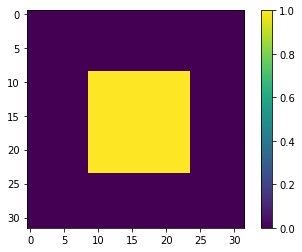

In [12]:
plt.imshow(output_opt[0])
plt.colorbar()

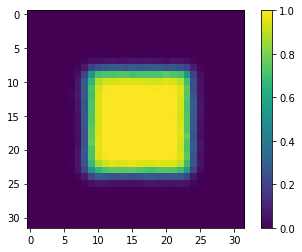

In [13]:
plt.imshow(output_opt[5])
plt.colorbar()

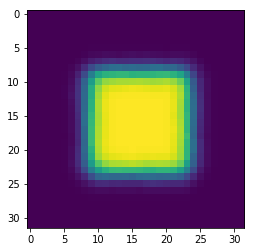

In [14]:
plt.imshow(output_opt[10])

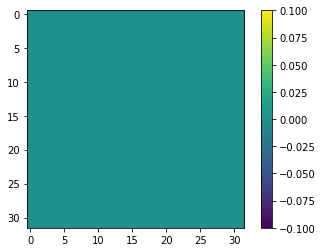

In [15]:
# validation against each other 
plt.imshow(output[10]- output_opt[10])
plt.colorbar()

Now I will present some asymmetric initial conditions. 

In [16]:
time_steps = 10
N = 64
# benchmarking used for report
start = time.time()
output_opt = discretise_OpenCL_Optimised(N, 
                                         time_steps, 
                                         True)
end = time.time()
print("Seconds elapsed for "+str(time_steps) 
      + " timesteps: " +str(end - start))

Seconds elapsed for 10 timesteps: 0.00319671630859375


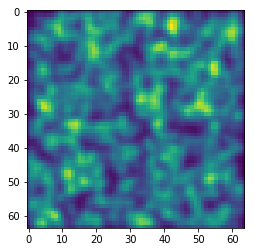

In [17]:
plt.imshow(output_opt[10])

In [18]:
time_steps = 10
N = 64
# benchmarking used for report
start = time.time()
output = discretise_OpenCL(N, 
                           time_steps, 
                           True)
end = time.time()
print("Seconds elapsed for "+str(time_steps) 
      + " timesteps: " +str(end - start))

Seconds elapsed for 10 timesteps: 0.0047223567962646484


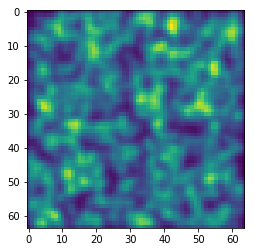

In [19]:
plt.imshow(output_opt[10])

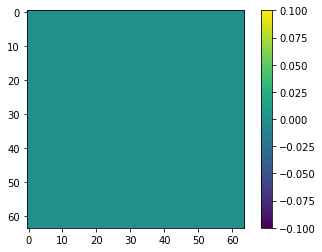

In [20]:
# verify against each other 
plt.imshow(output_opt[10]-output[10])
plt.colorbar()

# Benchmarking Code as Instructed by Project Description

In addition to the functions I used to create an array of different time steps to visualise the diffusion process, please find benchmarking code below as requested in the project description.

In [21]:
N = 32

In [22]:
# build an queue 
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
prg = cl.Program(ctx, kernel_string).build()
kernel = prg.discretiseOpenCL

def benchmarker_helper(in_grid, N, sigma):
    """
    Performs one forward time step of the Parabolic Poisson. 

    Parameters
    ----------
    in_grid : np.ndarray
        previous time step array 
    
    N : integer
        An integer describing the length of one 
        side of the grid
        
    sigma: np.ndarray
        Array of sigma values 

    Returns
    -------
    A (N, N, 2) float64 array describing time evolution
    """
    in_grid_copy = np.copy(in_grid) 
    in_grid = np.asarray([in_grid, in_grid_copy]) 
    
    # Setup buffers and kernel
    result_buffer = cl.Buffer(
        ctx, mf.COPY_HOST_PTR, hostbuf=in_grid)
               
    sigma_buffer = cl.Buffer(ctx, 
                             mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=sigma)
    
    kernel(queue,
           (N, N),
           (1, 1),
           np.int32(1),
           np.int32(N),
           result_buffer,
           sigma_buffer)
        
    cl.enqueue_copy(queue, in_grid, result_buffer)

    return in_grid

In [23]:
def benchmark(N, in_grid, sigma): 
    outputs = []
    start = time.time()
    for i in range(10):
        outputs.append(in_grid)
        output = benchmarker_helper(in_grid, N, sigma)
        in_grid = output[1]
    end = time.time()
    print("Seconds elapsed naive: " + str(end - start))
    return outputs  

In [24]:
# Add g(x, y) of choice 
in_grid = np.zeros((time_steps + 1, N, N), dtype='float64')
in_grid_init = in_grid[0]
in_grid_init = initial_conditions(in_grid_init)
# make a sigma vector, using the same random seed 
# so that the random values are the same at each iteration
seeder = RandomState(1234567890)
sigma = np.exp(seeder.normal(1, 0.2, (N+2)*(N+2), ))

In [25]:
output = benchmark(N, in_grid_init, sigma)

Seconds elapsed naive: 0.0016481876373291016


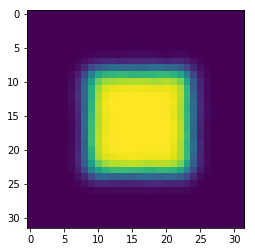

In [26]:
plt.imshow(output[9])

In [27]:
# build and queue 
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
prg = cl.Program(ctx, kernel_string_opt).build()
kernel = prg.discretiseOpenCLOpt

def benchmarker_helper_opt(in_grid, N, sigma):
    """
    Fills an array with ones near the centre. 

    Parameters
    ----------
    in_grid : np.ndarray
        previous time step array
        
    N : integer
        An integer describing the length of one 
        side of the grid
        
    sigma: np.ndarray
        Array of sigma values 

    Returns
    -------
    A (N, N, 2) float64 array describing time evolution
    """
    in_grid_copy = np.copy(in_grid) 
    in_grid = np.asarray([in_grid, in_grid_copy]) 
    
    # Setup buffers and kernel
    result_buffer = cl.Buffer(
        ctx, mf.COPY_HOST_PTR, hostbuf=in_grid)
               
    sigma_buffer = cl.Buffer(ctx, 
                             mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=sigma)
    
    kernel(queue,
           (N, N//8),
           (1, 1),
           np.int32(1),
           np.int32(N),
           result_buffer,
           sigma_buffer)
        
    cl.enqueue_copy(queue, in_grid, result_buffer)

    return in_grid

In [28]:
def benchmark_opt(N, in_grid, sigma): 
    outputs = []
    start = time.time()
    for i in range(10):
        outputs.append(in_grid)
        output = benchmarker_helper_opt(in_grid, N, sigma)
        in_grid = output[1]
    end = time.time()
    print("Seconds elapsed Optimised: " +str(end - start))
    return outputs 

In [29]:
output_opt = benchmark_opt(N, in_grid_init, sigma)

Seconds elapsed Optimised: 0.0015468597412109375


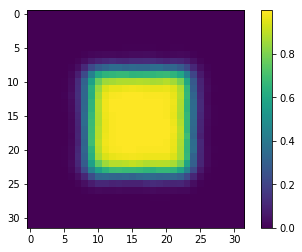

In [30]:
plt.imshow(output_opt[9])
plt.colorbar()